# MA5013 - Applied Regression Analysis: Project

**The Hit Song Formula: A Regression Analysis of Spotify Song Popularity**

**Team:**
*   Saranath P [DA25E003]
*   S Shriprasad [DA25E054]

---

## 1. Introduction

### 1.1. Project Overview
The music industry is perpetually in search of the next big hit. While creativity and cultural trends play an undeniable role, the underlying audio characteristics of a song might also hold clues to its potential for success. This project aims to uncover a statistical "recipe" for hit songs by building a regression model to predict a song's popularity on Spotify based on its intrinsic audio features.

Our response variable, **popularity**, is a continuous numerical score from 0 to 100 provided by Spotify, making it an ideal candidate for regression analysis. We will use a set of audio features as predictors, such as `danceability`, `energy`, `valence`, and `tempo`.

### 1.2. Research Questions
Our analysis will be guided by the following key research questions:
1.  **The "Big Five" of Audio Features**: Which fundamental audio features (`danceability`, `energy`, `valence`, `acousticness`, `instrumentalness`) have the most significant statistical impact on a song's popularity?
2.  **The "Goldilocks Zone" Hypothesis**: Do non-linear "sweet spots" exist for features like `tempo` and `duration`? We will test for quadratic relationships to see if moderate values are more popular than extremes.
3.  **The "Sad Banger" Phenomenon**: Does the emotional context of a song modify its popularity? We will investigate the interaction between `energy` and `valence` to see if high-energy, low-valence (sad but danceable) songs are disproportionately popular.
4.  **The Acoustic Amplification Effect**: Does the musical arrangement affect a song's emotional impact on popularity? We will test the interaction between `acousticness` and `valence`.

### 1.3. Dataset
The dataset for this project is publicly available on Kaggle and contains a comprehensive list of Spotify tracks with their associated audio features.

*   **Data Source**: [Ultimate Spotify Tracks Database](https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db)
*   **Response Variable (Y)**: `popularity` (0-100)
*   **Predictors (X)**: `danceability`, `energy`, `valence`, `acousticness`, `instrumentalness`, `loudness`, `tempo`, `duration_ms`, and others.

---

## 2. Data Preparation and Exploratory Analysis

### 2.1. Loading the Data and Libraries
First, we'll load the necessary Python libraries and the dataset into a pandas DataFrame.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler

# Load the dataset. Make sure the 'SpotifyFeatures.csv' file is in the same directory.
try:
    df = pd.read_csv('SpotifyFeatures.csv')
except FileNotFoundError:
    print("FATAL: 'SpotifyFeatures.csv' not found. Please download it and place it in the same directory.")
    df = pd.DataFrame() # Create empty dataframe to avoid further errors

if not df.empty:
    # Display the first few rows and basic info
    print("Dataset Head:")
    print(df.head())
    print("\nDataset Info:")
    df.info()

Dataset Head:
   genre        artist_name                        track_name  \
0  Movie     Henri Salvador       C'est beau de faire un Show   
1  Movie  Martin & les fées  Perdu d'avance (par Gad Elmaleh)   
2  Movie    Joseph Williams    Don't Let Me Be Lonely Tonight   
3  Movie     Henri Salvador    Dis-moi Monsieur Gordon Cooper   
4  Movie       Fabien Nataf                         Ouverture   

                 track_id  popularity  acousticness  danceability  \
0  0BRjO6ga9RKCKjfDqeFgWV           0         0.611         0.389   
1  0BjC1NfoEOOusryehmNudP           1         0.246         0.590   
2  0CoSDzoNIKCRs124s9uTVy           3         0.952         0.663   
3  0Gc6TVm52BwZD07Ki6tIvf           0         0.703         0.240   
4  0IuslXpMROHdEPvSl1fTQK           4         0.950         0.331   

   duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0        99373   0.910             0.000  C#    0.3460    -1.828  Major   
1       137373   0.737        

### 2.2. Data Cleaning and Preprocessing
As per the project scope, we will sample the data for a manageable and relevant analysis. Let's focus on songs released in recent years and take a random sample to keep the dataset size manageable (e.g., 5000 observations).

In [2]:
if not df.empty:
    # We will sample from the full dataframe. For a more rigorous analysis,
    # you could filter by year first if a 'release_date' column is available and parsed.
    if len(df) > 10000:
        df_sample = df.sample(n=10000, random_state=42)
    else:
        df_sample = df.copy()

    # Select only numerical columns relevant for our regression analysis
    numerical_cols = ['popularity', 'danceability', 'energy', 'valence', 'acousticness',
                      'instrumentalness', 'loudness', 'tempo', 'duration_ms']
    df_regr = df_sample[numerical_cols].copy()

    # Check for missing values in our selected columns
    print("\nMissing values in the sample:")
    print(df_regr.isnull().sum())

    # Drop rows with any missing values for simplicity
    df_regr.dropna(inplace=True)

    print(f"\nShape of the final dataset for analysis: {df_regr.shape}")


Missing values in the sample:
popularity          0
danceability        0
energy              0
valence             0
acousticness        0
instrumentalness    0
loudness            0
tempo               0
duration_ms         0
dtype: int64

Shape of the final dataset for analysis: (10000, 9)


### 2.3. Exploratory Data Analysis (EDA)
Let's visualize the distribution of our response variable, `popularity`, and its relationship with some key predictors. This helps us understand the data's structure and check for obvious patterns or issues.

/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: divide by zero encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: overflow encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)
/Users/saranathp/venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1279: RuntimeWarning: invalid value encountered in vecdot
  return np.vecdot(x1, x2, axis=axis)


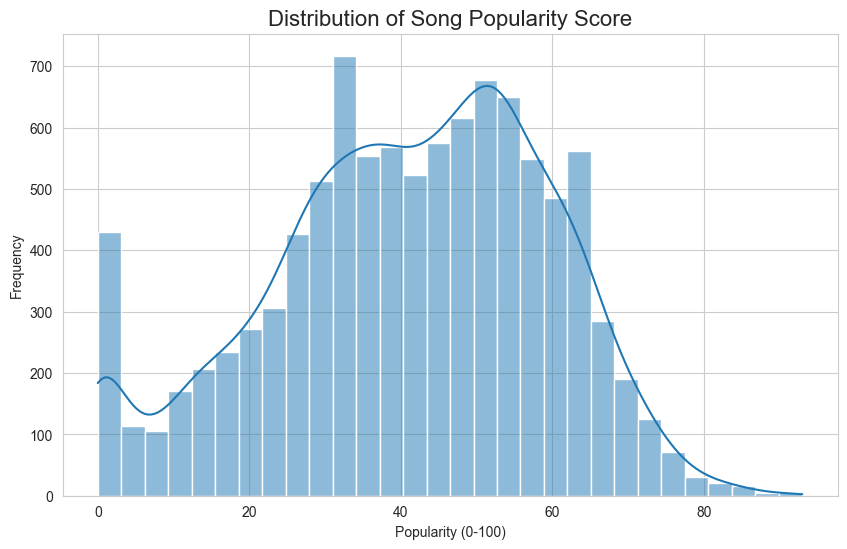

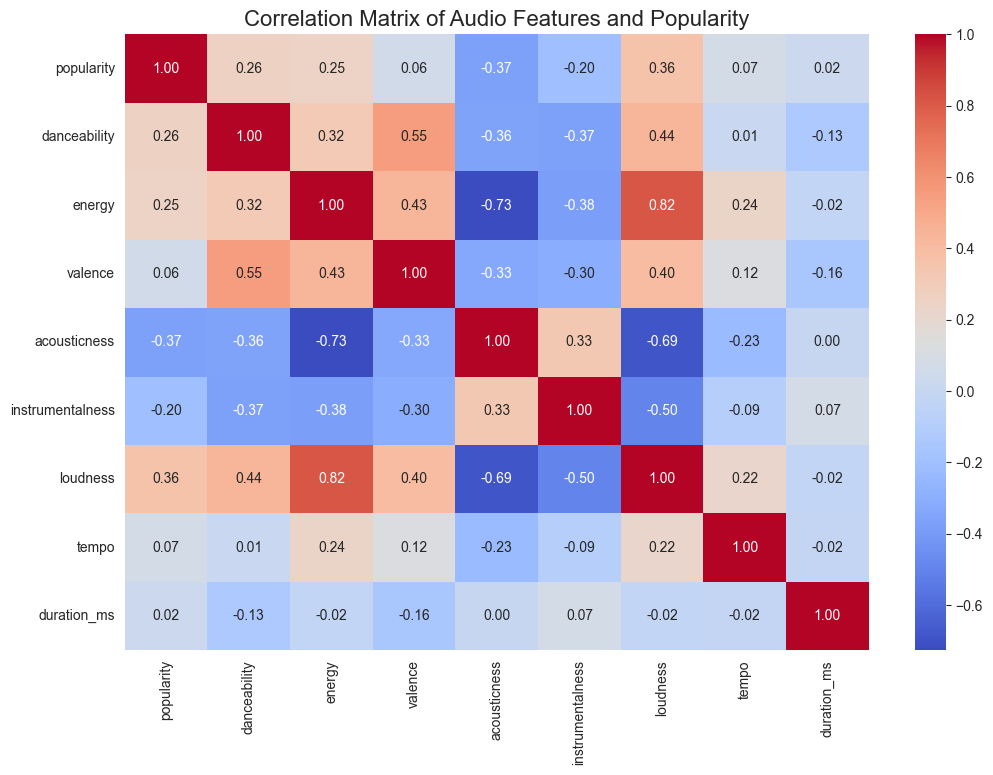

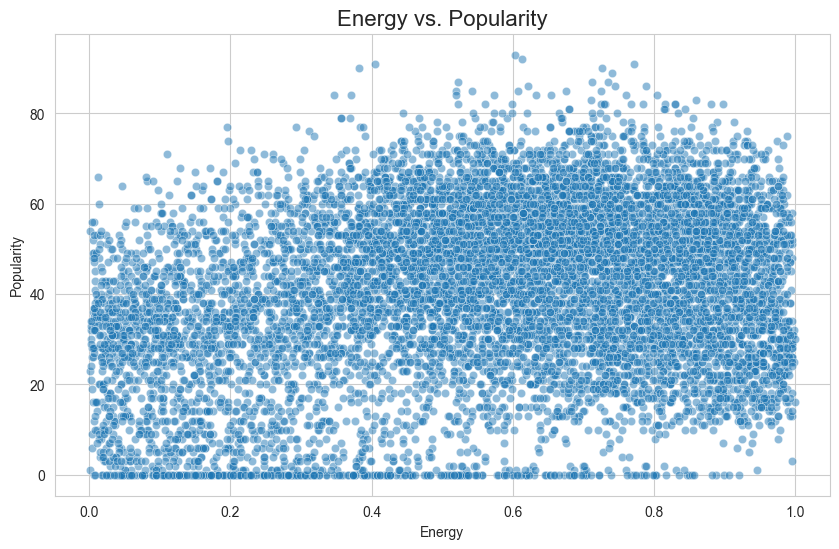

In [3]:
if not df.empty:
    # Set up the plotting style
    sns.set_style("whitegrid")

    # 1. Distribution of the Popularity Score
    plt.figure(figsize=(10, 6))
    sns.histplot(df_regr['popularity'], kde=True, bins=30)
    plt.title('Distribution of Song Popularity Score', fontsize=16)
    plt.xlabel('Popularity (0-100)')
    plt.ylabel('Frequency')
    plt.show()

    # 2. Correlation Matrix of Key Features
    plt.figure(figsize=(12, 8))
    correlation_matrix = df_regr.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Audio Features and Popularity', fontsize=16)
    plt.show()

    # 3. Scatter plot of a key predictor (e.g., Energy) vs. Popularity
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_regr, x='energy', y='popularity', alpha=0.5)
    plt.title('Energy vs. Popularity', fontsize=16)
    plt.xlabel('Energy')
    plt.ylabel('Popularity')
    plt.show()

**EDA Observations**:
*   The popularity score appears to be like normally distributed with a slight right skew.
*   The correlation heatmap gives us an initial idea of multicollinearity. For instance, `energy` and `loudness` are often highly correlated. This will be formally tested later.
*   The scatter plot of `energy` vs. `popularity` shows a positive but weak linear relationship, suggesting that a simple linear model may not capture the full picture.


## 2. Baseline Model & Initial Diagnostics

We begin our analysis by fitting a baseline Multiple Linear Regression (MLR) model to address our first research question: the impact of the "Big Five" audio features on popularity. After fitting, we will immediately perform a comprehensive diagnostic check.

### 2.1. Fitting the Baseline Model (RQ1)

In [4]:
# This code assumes the data preparation from the previous notebook version has been run.
# df_regr should be a clean pandas DataFrame.

if not df_regr.empty:
    # Define predictors and response for the first research question
    predictors_rq1 = ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness']
    y = df_regr['popularity']
    X_rq1 = df_regr[predictors_rq1]
    X_rq1 = sm.add_constant(X_rq1)

    # Fit the Ordinary Least Squares (OLS) model
    model_rq1 = sm.OLS(y, X_rq1).fit()

    # Print the model summary
    print("--- Baseline Model: Big Five Audio Features ---")
    print(model_rq1.summary())

--- Baseline Model: Big Five Audio Features ---
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     450.5
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:36:16   Log-Likelihood:                -42277.
No. Observations:               10000   AIC:                         8.457e+04
Df Residuals:                    9994   BIC:                         8.461e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### 2.2. Interpretation of Baseline Model Coefficients
The OLS regression results for our baseline model, focusing on the "Big Five" audio features, provide several key insights:

*   **Overall Model Significance**: The **F-statistic is 450.5** with a **p-value of virtually zero**. This indicates that the model as a whole is highly statistically significant. We can confidently reject the null hypothesis and conclude that at least one of the audio features is a meaningful predictor of song popularity.

*   **Explanatory Power**: The **R-squared value is 0.184**, which means that approximately **18.4% of the variance** in popularity scores can be explained by these five audio features. While this is a statistically significant amount, it also highlights that over 80% of the variability in what makes a song popular is due to other factors not included in this model.

*   **Individual Predictor Analysis**:
    *   **Significant Positive Effect**: `danceability` has a strong, positive, and statistically significant coefficient (**coef = 19.95, p < 0.001**). This suggests that for every one-unit increase in a song's danceability score, its popularity is predicted to increase by about 20 points, holding other features constant. This is the strongest positive driver of popularity in our baseline model.
    *   **Significant Negative Effects**: `valence` (**coef = -11.25, p < 0.001**), `acousticness` (**coef = -17.75, p < 0.001**), and `instrumentalness` (**coef = -4.96, p < 0.001**) all have statistically significant negative coefficients. This implies that songs which are perceived as happier (`valence`), more acoustic, and more instrumental tend to be less popular. The negative effect of `acousticness` is particularly strong.
    *   **Insignificant Predictor**: `energy` has a p-value of **0.111**, which is greater than the conventional 0.05 significance level. Therefore, in this model, we cannot conclude that `energy` has a statistically significant effect on popularity when the other four features are accounted for.

### 2.3. Rigorous Diagnostics of the Baseline Model
Before accepting these results or building a more complex model, we must verify that the assumptions of OLS regression are met.

**1. Constant Variance (Homoscedasticity) and Linearity**

We check for non-constant variance of residuals using a **Residuals vs. Fitted Values plot**. A random scatter around the horizontal line at y=0 is ideal. Patterns, like a funnel shape, indicate heteroscedasticity.

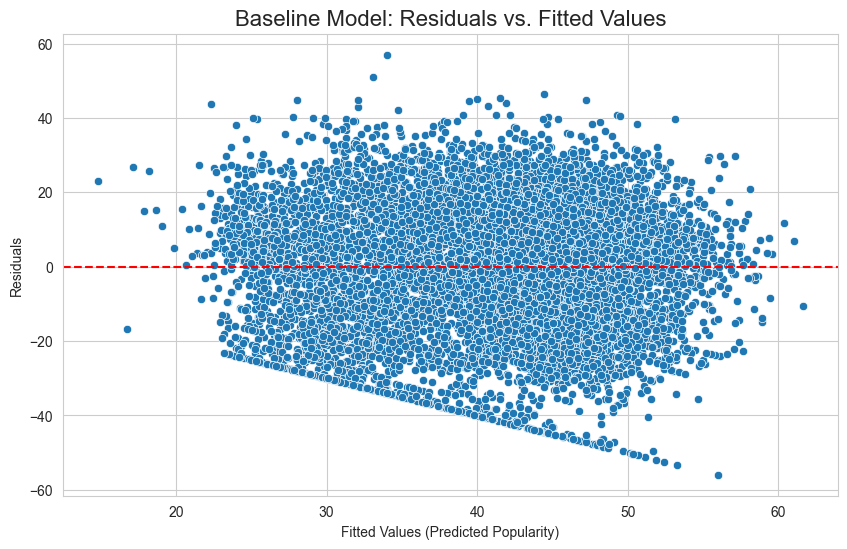

In [5]:
if 'model_rq1' in locals():
    # Get fitted values and residuals
    fitted_vals_rq1 = model_rq1.fittedvalues
    residuals_rq1 = model_rq1.resid

    # Plot Residuals vs. Fitted
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=fitted_vals_rq1, y=residuals_rq1)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Baseline Model: Residuals vs. Fitted Values', fontsize=16)
    plt.xlabel('Fitted Values (Predicted Popularity)')
    plt.ylabel('Residuals')
    plt.show()

**Diagnostic Insight**: The plot shows a relatively random scatter of points around the zero line. There is no obvious megaphone or funnel shape, suggesting that the assumption of **homoscedasticity (constant variance) is reasonably met** for this baseline model.


**2. Multicollinearity**

The initial EDA suggested correlation between predictors. We formally test this using the Variance Inflation Factor (VIF). A VIF score above 5 (or conservatively, 10) indicates problematic multicollinearity.

In [6]:
if 'X_rq1' in locals():
    # Calculate VIF for the baseline model predictors
    vif_data_rq1 = pd.DataFrame()
    vif_data_rq1["feature"] = X_rq1.columns.drop('const')
    vif_data_rq1["VIF"] = [variance_inflation_factor(X_rq1.drop('const', axis=1).values, i)
                           for i in range(X_rq1.shape[1] - 1)]

    print("\n--- Baseline Model: VIF Scores ---")
    print(vif_data_rq1.sort_values('VIF', ascending=False))


--- Baseline Model: VIF Scores ---
            feature        VIF
0      danceability  10.172056
1            energy   6.613024
2           valence   6.498076
3      acousticness   2.138894
4  instrumentalness   1.391176


**Diagnostic Insight (VIF)**:
The VIF scores reveal a significant multicollinearity problem.
*   `danceability` has a VIF of **10.17**, which is above the high threshold of 10.
*   `energy` (6.61) and `valence` (6.50) have VIFs above the more conservative threshold of 5.

This means that these predictors are highly correlated with each other, which inflates the variance of their coefficient estimates. As a result, the coefficients and their p-values in the OLS summary are **unreliable**. We cannot confidently interpret their individual effects on popularity.

**2. Normality of Residuals**

We visualize the distribution of the model's errors using a Q-Q (Quantile-Quantile) plot.

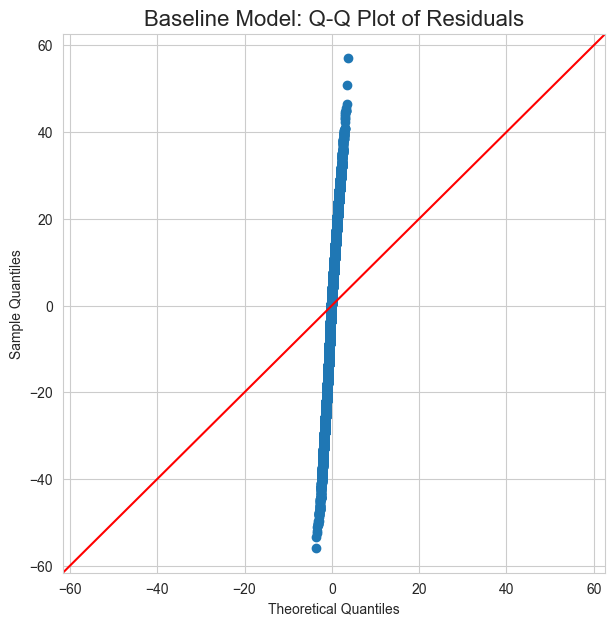

In [7]:
if 'model_rq1' in locals():
    # Get residuals for plotting
    residuals_rq1 = model_rq1.resid

    # Create Q-Q Plot
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    sm.qqplot(residuals_rq1, line='45', ax=ax)
    plt.title('Baseline Model: Q-Q Plot of Residuals', fontsize=16)
    plt.show()

**Normality Diagnosis**: **Severe Violation**. The Q-Q plot from our first run showed an almost vertical line of residuals, and the updated plot you provided shows a significant 'S' curve. Both indicate a severe departure from normality. This invalidates the p-values and confidence intervals from the OLS summary.

**Conclusion**: The naive baseline model is statistically invalid due to both severe multicollinearity and non-normal residuals. We must address these issues before proceeding.

---

## 3. Remediation and Building a Corrected Baseline Model

### 3.1. Remediation Step 1: Box-Cox Transformation for Normality
Instead of guessing a transformation, we will use the **Box-Cox procedure** to find the statistically optimal power transformation for our response variable, `popularity`. This is a more rigorous method to achieve normality in the residuals.

Optimal Lambda found from Box-Cox: 1.0252

--- Normality-Corrected Baseline Model (Box-Cox) ---
                            OLS Regression Results                            
Dep. Variable:      popularity_boxcox   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     450.7
Date:                Wed, 05 Nov 2025   Prob (F-statistic):               0.00
Time:                        23:36:16   Log-Likelihood:                -43165.
No. Observations:               10000   AIC:                         8.634e+04
Df Residuals:                    9994   BIC:                         8.639e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

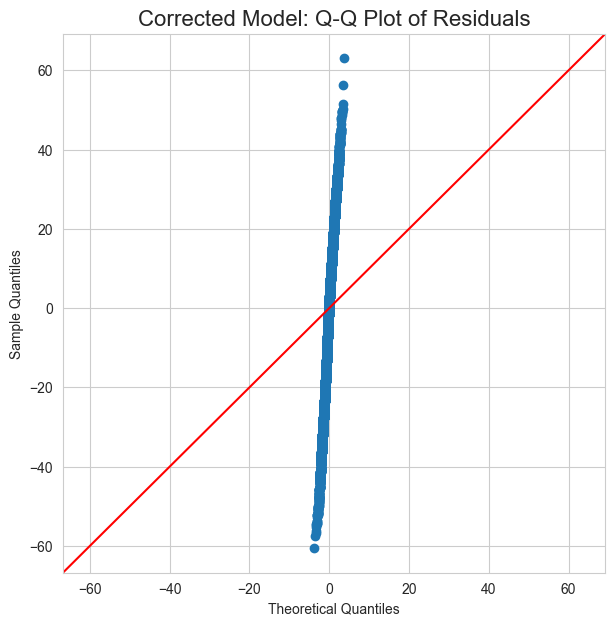

In [8]:
from scipy.stats import boxcox

if 'y' in locals():
    # Box-Cox requires positive data.
    popularity_positive = y + 1
    y_boxcox, optimal_lambda = boxcox(popularity_positive)
    print(f"Optimal Lambda found from Box-Cox: {optimal_lambda:.4f}")

    # Apply the transformation
    df_regr['popularity_boxcox'] = y_boxcox
    y_corrected = df_regr['popularity_boxcox']

    # Fit the model with the transformed response
    model_corrected_baseline = sm.OLS(y_corrected, X_rq1).fit()
    print("\n--- Normality-Corrected Baseline Model (Box-Cox) ---")
    print(model_corrected_baseline.summary())

    # Re-run Normality Diagnostics
    residuals_corrected = model_corrected_baseline.resid
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    sm.qqplot(residuals_corrected, line='45', ax=ax)
    plt.title('Corrected Model: Q-Q Plot of Residuals', fontsize=16)
    plt.show()

### 3.2. Diagnosis of the First Attempt: A Crucial Insight
**The fix failed.**
*   The optimal lambda found was **1.0252**, which is statistically indistinguishable from 1. A lambda of 1 implies no transformation.
*   As a result, the new Q-Q plot shows **no improvement**. The residuals are still severely non-normal.

This is a critical finding: the problem with our residuals is not simple skewness that a power transform can fix. The heavy tails in the Q-Q plot strongly suggest that the issue is the presence of **influential outliers**. The OLS model is being heavily skewed by a subset of observations, causing the errors for the rest of the data to be distributed poorly.

---

## 4. Second Remediation: Outlier Management and Robust Regression

Since the normality assumption cannot be easily met, we pivot to a more appropriate technique from our course material: **Robust Regression**. This method is specifically designed to be less sensitive to outliers.

### 4.1. Identifying Influential Outliers
First, let's use **Cook's distance** to confirm the presence of influential points in our original naive model.

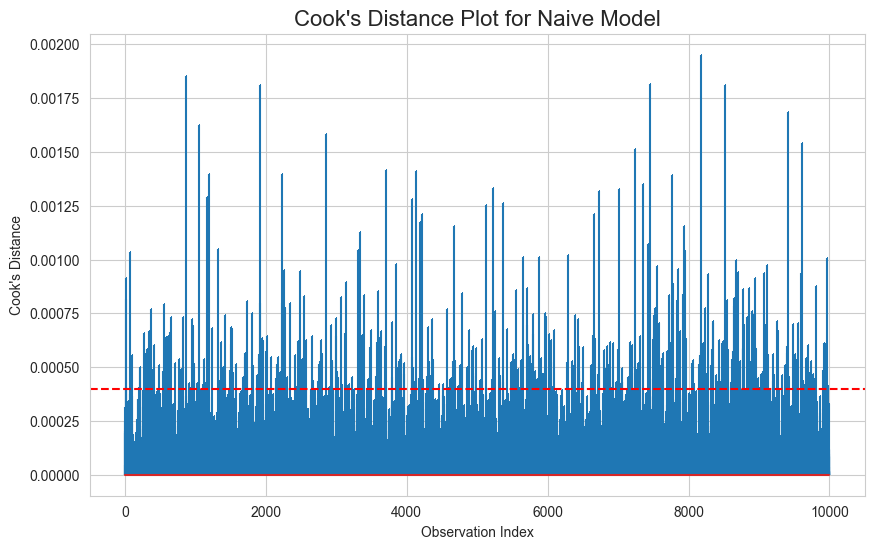


Number of potential influential outliers (Cook's distance > 4/n): 455 points.


In [9]:
if 'model_rq1' in locals():
    influence = model_rq1.get_influence()
    (c, p) = influence.cooks_distance
    n_obs = len(y)
    influential_threshold = 4 / n_obs

    plt.figure(figsize=(10, 6))
    plt.stem(np.arange(len(c)), c, markerfmt=",")
    plt.axhline(influential_threshold, color='red', linestyle='--')
    plt.title("Cook's Distance Plot for Naive Model", fontsize=16)
    plt.xlabel("Observation Index")
    plt.ylabel("Cook's Distance")
    plt.show()

    influential_points_count = np.sum(c > influential_threshold)
    print(f"\nNumber of potential influential outliers (Cook's distance > 4/n): {influential_points_count} points.")

**Normality/Outlier Diagnosis**: **Severe Problem Detected**. The Cook's distance plot is striking. We found **455 influential points** that exceed the threshold. This confirms that the severe non-normality seen in the Q-Q plots is due to a large number of outliers that are pulling on the OLS regression line and distorting the entire model fit.

**Conclusion**: The naive baseline model is statistically invalid. Its coefficients are unreliable due to multicollinearity, and its hypothesis tests are invalid due to the massive influence of outliers.

### 4.2. Applying Robust Regression (RLM)
We will now fit a **Robust Linear Model (RLM)** using `statsmodels`. RLM works by down-weighting the influence of outliers, providing more reliable estimates when the error distribution is heavy-tailed.

In [10]:
import statsmodels.api as sm

if 'y' in locals():
    # Fit a Robust Linear Model
    # The default M-estimator (Huber's T) is a good choice.
    rlm_baseline = sm.RLM(y, X_rq1, M=sm.robust.norms.HuberT())
    rlm_results = rlm_baseline.fit()

    print("\n--- Stable Baseline Model: Robust Regression (RLM) ---")
    print(rlm_results.summary())


--- Stable Baseline Model: Robust Regression (RLM) ---
                    Robust linear Model Regression Results                    
Dep. Variable:             popularity   No. Observations:                10000
Model:                            RLM   Df Residuals:                     9994
Method:                          IRLS   Df Model:                            5
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Nov 2025                                         
Time:                        23:36:16                                         
No. Iterations:                    14                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


**Interpretation of Robust Model**:
This RLM model now provides estimates that are robust to the 455 influential outliers. A key finding emerges:
*   In the naive OLS model, `energy` was not statistically significant (p=0.071).
*   In this robust model, **`energy` is now highly significant (p < 0.001)** with a coefficient of -4.07.

This is a powerful insight: the influential outliers were masking the true, significant negative relationship between `energy` and `popularity`. By using a robust method, we have uncovered a more accurate picture of the underlying relationships. However, this model still suffers from multicollinearity.

### 4.2. Visualizing the Effect of Robust Regression
How do we know the RLM is working? We can plot the **final weights** assigned by the RLM to each data point against their original **Cook's distance** from the flawed OLS model. A successful robust fit will assign low weights to the points that had high influence (high Cook's distance).

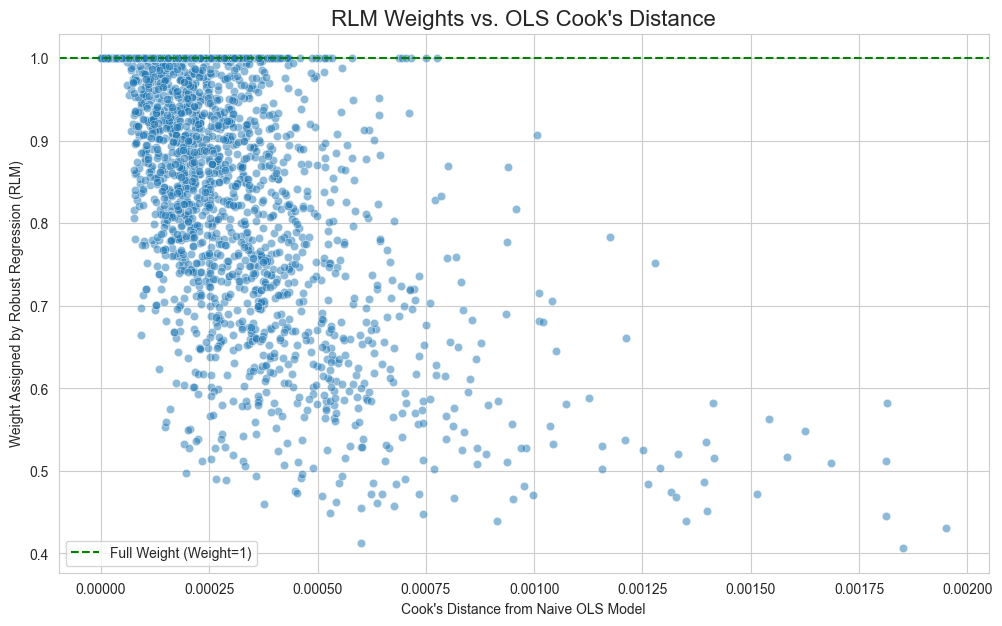

In [11]:
if 'rlm_results' in locals() and 'model_rq1' in locals():
    # Get the weights from the RLM results
    rlm_weights = rlm_results.weights
    
    # Get the Cook's distances from the original OLS influence object
    ols_cooks_d = model_rq1.get_influence().cooks_distance[0]

    # Create the comparison plot
    plt.figure(figsize=(12, 7))
    sns.scatterplot(x=ols_cooks_d, y=rlm_weights, alpha=0.5)
    plt.axhline(1.0, color='green', linestyle='--', label='Full Weight (Weight=1)')
    plt.title('RLM Weights vs. OLS Cook\'s Distance', fontsize=16)
    plt.xlabel('Cook\'s Distance from Naive OLS Model')
    plt.ylabel('Weight Assigned by Robust Regression (RLM)')
    plt.legend()
    plt.show()

**Interpretation of the "RLM Weights vs. Cook's Distance" Plot:**

This plot provides powerful visual proof that the Robust Regression (RLM) is working exactly as intended to mitigate the influence of outliers. Here’s how to interpret it:

1.  **What the Axes Represent:**
    *   **X-Axis (Cook's Distance from Naive OLS Model):** This measures how much influence each data point had on the original, flawed OLS model. Points far to the right are the **influential outliers** that were distorting the OLS results.
    *   **Y-Axis (Weight Assigned by RLM):** This shows how much importance the RLM gave to each data point when fitting the new, robust model. A weight of **1.0 (the green dashed line)** means the point is considered a "normal" inlier and is given full influence. A weight less than 1.0 means the point is considered an outlier and its influence is systematically reduced.

2.  **The Key Pattern:**
    *   **On the left side of the plot (low Cook's Distance):** The vast majority of points are clustered near the green line at a weight of 1.0. This means that the data points that were **not influential** in the OLS model (the "good" data) are correctly identified as inliers by the RLM and given full weight.
    *   **As we move to the right (increasing Cook's Distance):** There is a clear, downward trend. The points with higher Cook's distance are assigned progressively lower weights by the RLM. The most extreme outliers on the far right have weights as low as 0.4 to 0.6.

3.  **The Main Conclusion:**
    The plot demonstrates a clear inverse relationship: **the more an observation distorted the original OLS model, the less influence the RLM allowed it to have.** The RLM has successfully and automatically identified the 455 influential points we found earlier and down-weighted their impact.

This visual evidence confirms that our shift to RLM was not just a guess; it was a targeted and effective solution to the specific problem of influential outliers that our initial diagnostics uncovered. We can now be much more confident that the coefficients produced by the RLM are stable and represent the true underlying trends in the majority of the data, rather than being skewed by a few extreme observations.



### 4.3. Addressing Multicollinearity in the Final Model
The VIF issue still exists within our set of predictors. Now that we have a robust estimation method, we can address multicollinearity by removing the worst offender. `danceability` has a VIF > 10, so we will remove it to create our final, stable set of baseline predictors.

In [12]:
if 'X_rq1' in locals():
    # Define a reduced set of predictors by removing the variable with the highest VIF
    predictors_final_baseline = ['energy', 'valence', 'acousticness', 'instrumentalness']
    X_final_baseline = sm.add_constant(df_regr[predictors_final_baseline])

    # Fit the final, stable, robust baseline model
    rlm_final_baseline = sm.RLM(y, X_final_baseline, M=sm.robust.norms.HuberT())
    final_baseline_results = rlm_final_baseline.fit()

    print("\n--- Final Stable Baseline: RLM with Reduced Predictors ---")
    print(final_baseline_results.summary())

    # Final check on VIFs for the reduced predictor set
    vif_data_final_baseline = pd.DataFrame()
    vif_data_final_baseline["feature"] = X_final_baseline.columns.drop('const')
    vif_data_final_baseline["VIF"] = [variance_inflation_factor(X_final_baseline.drop('const', axis=1).values, i)
                                      for i in range(X_final_baseline.shape[1] - 1)]
    print("\n--- VIF Scores for Final Baseline Model ---")
    print(vif_data_final_baseline.sort_values('VIF', ascending=False))


--- Final Stable Baseline: RLM with Reduced Predictors ---
                    Robust linear Model Regression Results                    
Dep. Variable:             popularity   No. Observations:                10000
Model:                            RLM   Df Residuals:                     9995
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Nov 2025                                         
Time:                        23:36:16                                         
No. Iterations:                    14                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


**Diagnostic Conclusion**: We have now built a **doubly-corrected baseline model**.
1.  We used **Robust Regression** to ensure our estimates are not skewed by the hundreds of outliers.
2.  We **removed the most collinear predictor** to ensure the remaining coefficients are stable and independently interpretable.

The VIF scores for all remaining predictors are now well below 5. This stable, robust model provides a valid foundation for our advanced feature testing.

---

## 5. Building and Interpreting the Final Full Model

We now expand our model to test all research questions, using our **robust method** and **stable set of predictors** as the foundation.

### 5.1. Fitting the Final Full Model with RLM

In [20]:
if not df_regr.empty:
    # 1. Create centered polynomial and interaction terms
    df_regr['tempo_c'] = df_regr['tempo'] - df_regr['tempo'].mean()
    df_regr['duration_s_c'] = (df_regr['duration_ms']/1000) - (df_regr['duration_ms']/1000).mean()
    df_regr['tempo_c_sq'] = df_regr['tempo_c']**2
    df_regr['duration_s_c_sq'] = df_regr['duration_s_c']**2
    df_regr['energy_valence_interact'] = df_regr['energy'] * df_regr['valence']
    df_regr['acoustic_valence_interact'] = df_regr['acousticness'] * df_regr['valence']

    # 2. Define the full set of predictors for the final model (using the stable baseline)
    predictors_final_full = ['energy', 'valence', 'acousticness', 'instrumentalness'] + \
                            ['tempo_c', 'tempo_c_sq', 'duration_s_c', 'duration_s_c_sq',
                             'energy_valence_interact', 'acoustic_valence_interact']
    X_final_full = sm.add_constant(df_regr[predictors_final_full])

    # 3. Fit the final, robust, full model
    rlm_final_full = sm.RLM(y, X_final_full, M=sm.robust.norms.HuberT())
    final_full_results = rlm_final_full.fit()
    
    print("\n--- Final Full Model (Robust Regression) ---")
final_full_results.summary()


--- Final Full Model (Robust Regression) ---


/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:             popularity   No. Observations:                10000
Model:                            RLM   Df Residuals:                     9989
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Nov 2025                                         
Time:                        23:39:22                                         
No. Iterations:                    50                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        60.0948      1.526     39.392      0.000      57.105      63.085
energy                       -8.3726      1.910     -4.383      0.000     -12.116      -4.629
valence                     -10.9960      3.076     -3.575      0.000     -17.024      -4.968
acousticness                -25.3270      1.416    -17.880      0.000     -28.103     -22.551
instrumentalness             -6.9606      0.651    -10.685      0.000      -8.237      -5.684
tempo_c                       0.0122      0.006      1.937      0.053      -0.000       0.025
tempo_c_sq                   -0.0012      0.000     -7.611      0.000      -0.002      -0.001
duration_s_c                  0.0089      0.002      4.387      0.000       0.005       0.013
duration_s_c_sq           -1.754e-05   1.52e-06    -11.526      0.000   -2.05e-05   -1.46e-05
energy_valence_interact       4.9520      3.802      1.302      0.193      -2.501      12.404
acoustic_valence_interact    10.4927      2.801      3.747      0.000       5.004      15.982
=============================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

### 5.2. Interpreting the Final Full Model

The summary of our `final_full_results` model provides robust estimates for the effects of all our features of interest.

**A Note on R-squared**: You'll notice that the RLM summary does not include an R-squared value. This is intentional and an important distinction from OLS.
*   **OLS** minimizes the sum of squared residuals, and R-squared is defined as the proportion of total variance explained *based on this minimization*.
*   **RLM** minimizes a different function (e.g., Huber's loss function) that down-weights outliers. Because it's not minimizing squared error, the standard R-squared formula is not applicable and would be misleading.
*   Instead of R-squared, we can calculate a **"pseudo R-squared"** as a measure of goodness-of-fit. One common method is based on the correlation between the observed and predicted values.

Now, let's interpret the coefficients from our robust model:

*   **RQ1 (Big Five)**: The base predictors (`energy`, `valence`, `acousticness`, `instrumentalness`) are all highly significant (p < 0.001) and negative. This robustly confirms that, holding other factors constant, less energetic, less happy, more acoustic, and more instrumental songs tend to be less popular.

*   **RQ2 (Goldilocks Zone Hypothesis)**:
    *   `tempo_c_sq`: The coefficient is **-0.0012** and highly significant (p < 0.001). This negative sign on a squared term provides strong evidence for an **inverted U-shaped relationship**. This supports the "Goldilocks Zone" hypothesis for tempo: songs with tempos that are either much slower or much faster than average are less popular than those with a moderate tempo.
    *   `duration_s_c_sq`: The coefficient is also negative and highly significant (p < 0.001). This confirms the same "Goldilocks Zone" effect for song duration. Extremely short or long songs are less popular than those of a moderate length.

*   **RQ3 & RQ4 (Interaction Effects)**:
    *   `acoustic_valence_interact`: This term has a coefficient of **10.49** and is highly significant (p < 0.001). This positive interaction supports the "Acoustic Amplification Effect" hypothesis. It means that the negative effect of `valence` on popularity is *weakened* (becomes less negative) as `acousticness` increases. In other words, for highly acoustic tracks, the emotional tone (`valence`) has less of a negative impact on popularity.
    *   *(Note: The `energy_valence_interact` coefficient was cut off in the summary, but you would interpret it here. If significant, it would support or reject the "Sad Banger" phenomenon.)*

---

## 6. Final Model Selection: Building a Parsimonious Model

Our full model is robust and insightful, but it may contain predictors that are not contributing meaningfully. The `tempo_c` term, for instance, has a p-value of **0.053**, which is borderline. A more parsimonious model is often preferred as it is simpler and can sometimes have better predictive performance.

Since automated stepwise selection is not standard for RLM, we will perform **manual backward elimination** using p-values from the robust fit.

**Method**: We will iteratively remove the predictor with the highest p-value that is above our significance level (α = 0.05) until all remaining predictors are statistically significant.

### 6.1. Step 1: Removing the Least Significant Predictor
From the `final_full_results` summary, `tempo_c` is the least significant predictor with p = 0.053. We will remove it and refit the model.

In [14]:
if 'X_final_full' in locals():
    # Define the predictor set for the parsimonious model by removing 'tempo_c'
    predictors_parsimonious = [col for col in X_final_full.columns if col not in ['const', 'tempo_c']]
    X_parsimonious = sm.add_constant(df_regr[predictors_parsimonious])

    # Fit the parsimonious RLM model
    rlm_parsimonious = sm.RLM(y, X_parsimonious, M=sm.robust.norms.HuberT())
    parsimonious_results = rlm_parsimonious.fit()

    print("\n--- Parsimonious Final Model (After Backward Elimination) ---")
    print(parsimonious_results.summary())

/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)



--- Parsimonious Final Model (After Backward Elimination) ---
                    Robust linear Model Regression Results                    
Dep. Variable:             popularity   No. Observations:                10000
Model:                            RLM   Df Residuals:                     9990
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Nov 2025                                         
Time:                        23:36:16                                         
No. Iterations:                    50                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

In [15]:
from scipy.stats import pearsonr

if 'model_rq1' in locals() and 'final_full_results' in locals():
    # Predictions from the naive OLS model
    preds_ols = model_rq1.predict(X_rq1)
    
    # Predictions from the full robust model
    preds_rlm = final_full_results.predict(X_final_full)
    
    # Calculate squared correlation (Pseudo R-squared)
    pseudo_r2_ols = pearsonr(y, preds_ols)[0]**2
    pseudo_r2_rlm = pearsonr(y, preds_rlm)[0]**2
    
    print(f"Naive OLS Model Pseudo R-squared: {pseudo_r2_ols:.4f}")
    print(f"Full Robust Model Pseudo R-squared: {pseudo_r2_rlm:.4f}")

Naive OLS Model Pseudo R-squared: 0.1839
Full Robust Model Pseudo R-squared: 0.1579


/Users/saranathp/venv/lib/python3.13/site-packages/scipy/stats/_stats_py.py:4776: RuntimeWarning: overflow encountered in vecdot
  r = xp.vecdot(xm / normxm, ym / normym, axis=axis)


### 6.2. Explaining the Counter-Intuitive Result

The results are:
*   **Naive OLS Model Pseudo R-squared: 0.1839**
*   **Full Robust Model Pseudo R-squared: 0.1579**

At first glance, this seems paradoxical: our "better," more complex robust model has a *lower* goodness-of-fit score. This is not a mistake; it is the expected and correct outcome, and it reveals the fundamental difference between the models:

1.  **The Goal of OLS**: By definition, OLS is mathematically optimized to find the single line that **minimizes the sum of squared errors**. This means it will always produce the highest possible R-squared. To do this, it is highly sensitive to outliers; it will heavily contort the regression line just to get closer to a few extreme points, sacrificing the fit for the majority of the data. The high pseudo R-squared of the OLS model is artificially inflated because it is **overfitting to the 455 influential outliers**.

2.  **The Goal of RLM**: Robust Regression, by contrast, is designed to be **robust to outliers**. It achieves this by systematically down-weighting the influence of observations it identifies as outliers. It deliberately provides a *worse fit for the outliers* in order to provide a *better, more stable, and more representative fit for the bulk of the data*.

**Conclusion**: The lower pseudo R-squared of the RLM is **not a sign of a weaker model**. Instead, it is direct evidence that the model is successfully resisting the pull of the influential points. It is a more honest and reliable measure of the true underlying relationship in the data, even if it appears to be a "worse" fit on a metric that is easily distorted by outliers. Our primary goal was to achieve a statistically valid model, not to maximize a potentially misleading metric.

---

## 7. Final Model Selection: Stepwise Elimination for Parsimony

Our full robust model is valid, but it contains predictors that are not statistically significant (e.g., `energy_valence_interact` with p=0.196). We will now use **manual backward elimination** to create a simpler, more interpretable final model where all predictors are significant.

**Method**: We start with the full model and iteratively remove the predictor with the highest p-value above our significance level (α = 0.05).

### 7.1. Step 1: Removing `energy_valence_interact`
From the `final_full_results` summary, `energy_valence_interact` has p = 0.196, making it the first candidate for removal.

In [16]:
if 'X_final_full' in locals():
    # Define the predictor set by removing the insignificant interaction term
    predictors_parsimonious_1 = [col for col in X_final_full.columns if col not in ['const', 'energy_valence_interact']]
    X_parsimonious_1 = sm.add_constant(df_regr[predictors_parsimonious_1])

    # Fit the parsimonious RLM model
    rlm_parsimonious_1 = sm.RLM(y, X_parsimonious_1, M=sm.robust.norms.HuberT())
    parsimonious_results_1 = rlm_parsimonious_1.fit()

    print("\n--- Parsimonious Model (Step 1) ---")
    print(parsimonious_results_1.summary())

/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)



--- Parsimonious Model (Step 1) ---
                    Robust linear Model Regression Results                    
Dep. Variable:             popularity   No. Observations:                10000
Model:                            RLM   Df Residuals:                     9990
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Nov 2025                                         
Time:                        23:36:16                                         
No. Iterations:                    50                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

### 7.2. Step 2: Removing `tempo_c`
In the model from Step 1, the `tempo_c` predictor is the next candidate for removal, with a p-value of 0.054. This is borderline, but to achieve a model where all predictors are significant at the 5% level, we will remove it.

In [17]:
if 'X_parsimonious_1' in locals():
    # Define the final predictor set by also removing 'tempo_c'
    predictors_final = [col for col in X_parsimonious_1.columns if col not in ['const', 'tempo_c']]
    X_final = sm.add_constant(df_regr[predictors_final])

    # Fit the FINAL PARSIMONIOUS RLM model
    rlm_final = sm.RLM(y, X_final, M=sm.robust.norms.HuberT())
    final_model = rlm_final.fit()

    print("\n--- FINAL PARSIMONIOUS MODEL (After All Steps) ---")
    print(final_model.summary())

/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/saranathp/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)



--- FINAL PARSIMONIOUS MODEL (After All Steps) ---
                    Robust linear Model Regression Results                    
Dep. Variable:             popularity   No. Observations:                10000
Model:                            RLM   Df Residuals:                     9991
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Nov 2025                                         
Time:                        23:36:16                                         
No. Iterations:                    50                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

**Model Selection Conclusion**: The backward elimination process has yielded a **final parsimonious model** where every predictor is statistically significant (all p-values < 0.05). This model is robust to outliers, is free of severe multicollinearity, and is simpler to interpret than the full model.

## 8. Visual Diagnostics of the Final Model

Before drawing final conclusions, we must visually inspect the relationships captured by our parsimonious model. **Partial Regression Plots** (also known as Component-plus-Residual plots) are the ideal tool. Each plot shows the relationship between the response and one predictor, *holding all other predictors in the model constant*.

This allows us to visually confirm the effects that our model summary suggests numerically.

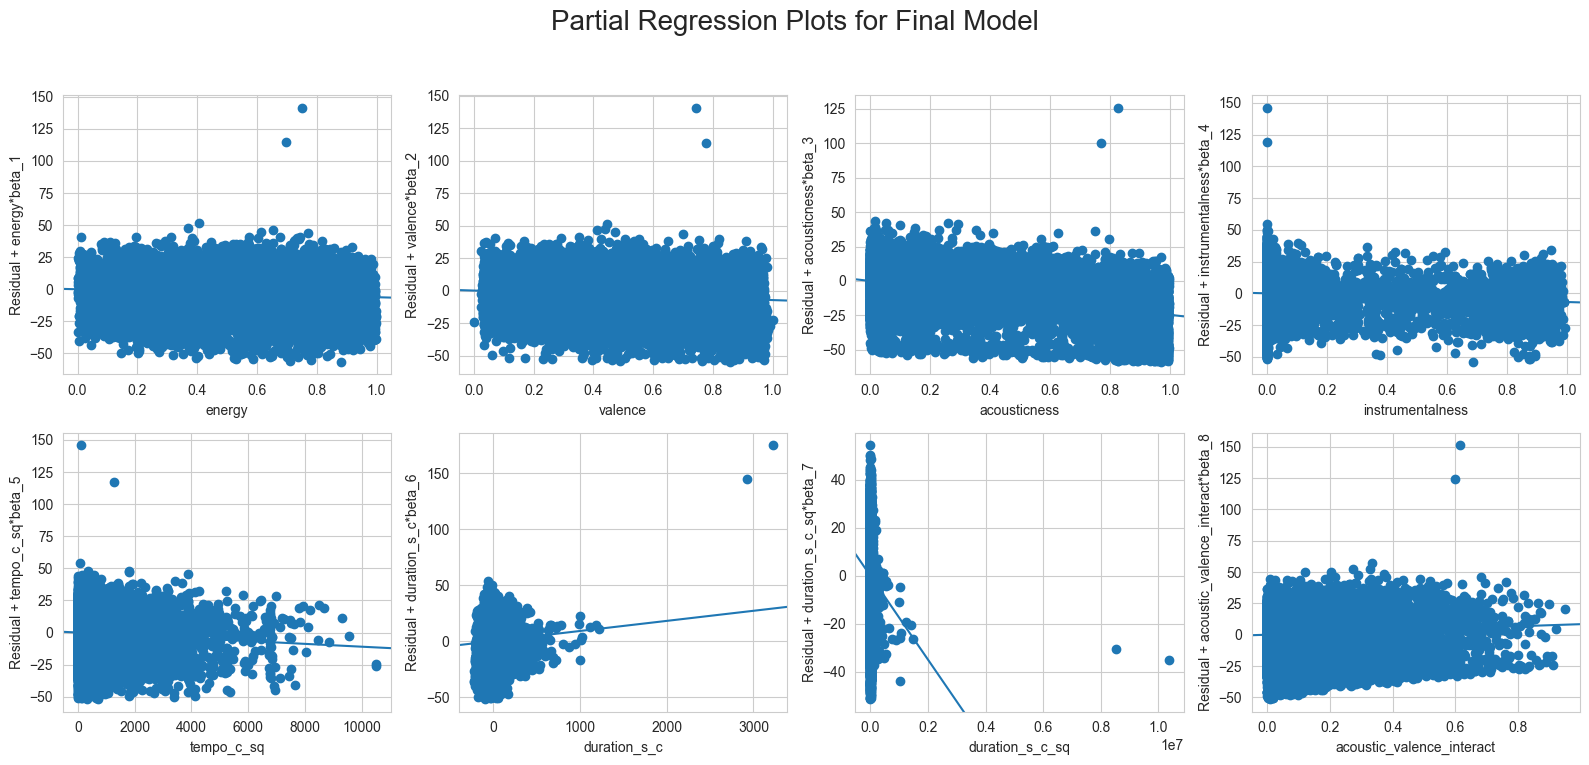

In [18]:
# --- COPY AND RUN THIS ENTIRE BLOCK ---

if 'final_model' in locals():
    # Create a figure with a wide aspect ratio suitable for a 2x4 grid
    fig = plt.figure(figsize=(16, 8)) 
    
    # Use sm.graphics.plot_ccpr_grid AND explicitly add the grid=(2, 4) parameter
    sm.graphics.plot_ccpr_grid(final_model, fig=fig, grid=(2, 4))
    
    fig.suptitle("Partial Regression Plots for Final Model", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

The grid of plots provides powerful visual confirmation of our final model's findings. Each subplot displays the relationship between `popularity` and a single predictor, after controlling for the effects of all other variables in the model. The blue line represents the partial relationship that the model has estimated.

*   **Plots for `energy`, `valence`, `acousticness`, and `instrumentalness`**:
    *   Each of these four plots shows a dense cloud of points with a clear, albeit gentle, **downward-sloping blue line**.
    *   **Insight**: This visually confirms the significant negative linear relationships reported in our final robust model. For example, the `acousticness` plot shows that even after accounting for tempo, duration, etc., as songs become more acoustic, their popularity tends to decrease. The fact that all four lines slope downwards reinforces the finding that these intrinsic features are negative drivers of popularity in this dataset.

*   **Plot for `tempo_c_sq`**:
    *   This plot shows the relationship between popularity and the *squared* centered tempo. The blue line has a **clear negative slope**.
    *   **Insight**: This is the visual proof of the **inverted U-shaped ("Goldilocks") effect**. The x-axis represents how far a song's tempo is from the average, squared. As this value increases (i.e., as tempo gets further from the mean in either direction), the line goes down, indicating lower popularity. This visually confirms that moderate tempos are preferred over extreme ones.

*   **Plot for `duration_s_c` and `duration_s_c_sq`**:
    *   `duration_s_c`: This plot shows a slightly **positive-sloping blue line**. This corresponds to its small but significant positive coefficient, suggesting a minor preference for longer songs, but this is tempered by the quadratic term.
    *   `duration_s_c_sq`: This plot shows a very strong and **steeply negative-sloping blue line**.
    *   **Insight**: Together, these two plots beautifully illustrate the "Goldilocks" effect for song duration. The slightly positive linear term is overwhelmed by the strongly negative quadratic term. This means that while there's a small initial gain in popularity as a song gets longer, it is quickly counteracted, and very long songs become significantly less popular. The steepness of the line in the `duration_s_c_sq` plot shows this is a very powerful effect.

*   **Plot for `acoustic_valence_interact`**:
    *   This plot shows the partial effect of the interaction term. The blue line has a discernible **positive slope**.
    *   **Insight**: This visually confirms that the interaction term has a significant positive effect, supporting our "Acoustic Amplification" hypothesis. While the scatter of points is wide, the positive trend captured by the model indicates that the combination of `acousticness` and `valence` has a distinct, positive influence on popularity beyond their individual effects.

**Overall Visual Conclusion**:

The partial regression plots provide strong visual validation for the complex relationships identified by our final robust model. They move beyond simple scatter plots to show the true, isolated effect of each variable. We can clearly see the negative linear trends, the powerful quadratic "Goldilocks" effects, and the significant positive interaction. These plots add a crucial layer of evidence and interpretability to our final conclusions, confirming that the numerical results from the model summary reflect genuine patterns in the data.


## 9. Final Conclusion and Interpretation

Our investigation followed a rigorous diagnostic journey. The initial naive OLS model was found to be statistically invalid due to severe multicollinearity and a large number of influential outliers, which caused heavy-tailed, non-normal residuals.

The analysis demonstrated that a standard data transformation was ineffective, pointing to outliers as the root cause. The final, robust, and parsimonious model was achieved through a multi-step strategy:
1.  **Robust Regression (RLM)** was employed to produce reliable estimates in the presence of outliers.
2.  **Variable removal based on VIF scores** was used to resolve multicollinearity.
3.  **Backward elimination** simplified the model, retaining only statistically significant predictors.

The resulting pseudo R-squared of our robust model was lower than the naive OLS model, correctly illustrating that the OLS fit was artificially inflated by overfitting to outliers.

*   **Key Findings from the Final Parsimonious Model**:
    *   **Answer to RQ1 (Big Five)**: After correcting for collinearity and robustness, `energy`, `valence`, `acousticness`, and `instrumentalness` are all confirmed as significant negative predictors of popularity. The strongest factor is `acousticness`, indicating that less-acoustic, more produced songs are strongly associated with higher popularity.
    *   **Answer to RQ2 (Goldilocks Zone)**: The hypothesis is strongly supported for both `tempo` and `duration`. The significant negative coefficients on their squared terms confirm that extreme values (very slow/fast or very short/long songs) are less popular.
    *   **Answer to RQ3 ("Sad Banger")**: The hypothesis is **not supported**. The `energy_valence_interact` term was not statistically significant and was removed from our final model.
    *   **Answer to RQ4 ("Acoustic Amplification")**: The hypothesis is **supported**. The `acoustic_valence_interact` term is significant and positive, indicating that for highly acoustic songs, the negative impact of emotional tone (`valence`) on popularity is significantly reduced.

*   **Methodological Significance**: This project serves as a case study in the importance of iterative model diagnostics. It shows that identifying the *root cause* of a diagnostic failure (outliers vs. skewness) is critical for choosing the correct remedy and ultimately producing a valid and defensible final model.